# Predicting BTC with Neural Networks

Hello and welcome to my Juptyer Notebook where I will try to answer the following question:

**What are the practical pros/cons of RNN and LSTM when it comes to predicting time series?**

To answer the question, I will be trying to predict Bitcoin prices from the publicly available data. The content will be broken up as follows:

## Table of Contents:

1. Modules
2. Data
    1. Cleaning
    2. Cursory look 
    3. Prepping  
3. The Models
    1. Summary of the models
        1. RNN
        2. LSTM
4. Predictions
    1. RNN
    2. LSTM
        1. LSTM 1 Layer
        2. LSTM 2 Layers
6. Comparison
7. Conclusion

# 1. Modules

First things first. We need to import all the needed [modules](https://docs.python.org/3/reference/import.html) for this project. Below, I've made a list and described each module and included a link for its website. Typically, to follow along, you just need to `pip install` any of these (for example, `pip install matplotlib`), unless you are using a version of [Anaconda](https://www.anaconda.com/), in which case, you can use `conda install` for any of these modules.


- [Numpy](http://www.numpy.org/) is an incredibly powerful tool that is used almost everywhere you encounter matrices in Python. We also use it mainly for its powerful operations on their N-dimensional array objects.

- [Pandas](https://pandas.pydata.org/) is a must for data science in Python. It handles powerful, expressive, and flexible data structures that allow easy data manipulation and analysis (among other things). Main thing to take away are the DataFrames.
- [StatsModels](https://www.statsmodels.org/stable/index.html) is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. It complements SciPy computations providing descriptive statistics and estimation and inference for statistical models.
- [SciPy](https://www.scipy.org/) contains modules for optimization, linear algebra, integration, interpoliation, and much more.
- [SkLearn](http://scikit-learn.org/stable/) is a Python module for machine learning built on top of SciPy 
- [Math](https://docs.python.org/3/library/math.html) is avaiable by default (i.e. no need to install separately!). This module includes common mathematical functions.
- [Random](https://docs.python.org/3/library/random.html) is a module that generates psuedo-random numbers from various distributions. 
- [Keras](https://keras.io/) is an open source neural network library.
- [Matplotlib](https://matplotlib.org/) is a plotting library. If you're familiar with MATLAB, then this should be familiar as well.
- [Plotly](https://plot.ly/python/) is an interactive, open-source, and browser-based graphing library for Python.


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


# 2. Data

The data we are using comes from [Kaggle](https://kaggle.com), which is an online community of data scientists and machine learners, owned by Google. Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

Specifically, you can check out this [site](https://www.kaggle.com/mczielinski/bitcoin-historical-data) to grab the data yourself.

Now we load up the data and do a little bit of data wrangling. We will load the data into a pandas dataframe and make sure of the following:
1. there are no nulls (if there are, we can figure out what to do then),
2. the format of the data is acceptable (i.e. datetime)
3. bin data as necessary (data will probably come to us in minute/hourly data given the nature of the machine-generated financial data) so we will need to bin the data (for now, we will go with daily updates).

In [3]:
# Let's load up the data into pandas dataframe called data
data = pd.read_csv('./Data/bitstampUSD_1-min_data_2012-01-01_to_2018-11-11.csv')

# We can double check the type of data. It should be dataframe.
type(data)

pandas.core.frame.DataFrame

Great!

Data is loaded into `data`. Note that since we used `pd` (i.e. `pandas`), data is a pandas DataFrame.

## Data Cleaning

As with any data science project, we need to get familar with our data. Let's take a **(1) look at the data** and **(2) clean the data as needed**.
- Check to see if any values are null in the dataframe. Keep in mind, we are looking at financial data that is machine generated, so we're unlikely to have any null values. If we do have any, it would be easy to fill in the gaps using a simple interpolation, but we'll cross that bridge if we have to.
- Take a look at the top 10 rows to look at the value and get a sense of what the data looks like.
- Scale data as needed.

In [4]:
# What does the first 10 rows look like?
data.tail(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
3603126,1541893800,6347.60,6347.60,6347.60,6347.60,0.643544,4084.959196,6347.600000
3603127,1541893860,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3603128,1541893920,6348.54,6348.54,6348.54,6348.54,0.079413,504.153750,6348.540000
3603129,1541893980,6348.54,6348.54,6348.54,6348.54,0.022749,144.422936,6348.540000
3603130,1541894040,6348.54,6348.54,6348.54,6348.54,0.007997,50.769274,6348.540000
3603131,1541894100,6348.54,6348.54,6348.54,6348.54,0.007997,50.769274,6348.540000
3603132,1541894160,6348.54,6349.01,6348.54,6349.01,0.011729,74.466671,6348.936090
3603133,1541894220,6349.01,6349.01,6349.01,6349.01,0.068436,434.503642,6349.010000
3603134,1541894280,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3603135,1541894340,6349.17,6349.32,6349.17,6349.32,0.038261,242.927410,6349.214148


Let's take note of a few things:

1. Take a look at the timestamp. The number you see is a Unix timestamp that captures the number of seconds since epoch (considered to be 1970-01-01 12AM). 
Take for instance, the first row (1325317980). That is equivalent to Saturday, December 31, 2011 7:52:00 AM (GMT) and the second row (1325317980) is the same as Saturday, December 31, 2011 7:53:00 AM. Mainly, notice that it is in the same day. So for the time being, we will look at data partitioned by day, so we're going to need to get the average price grouped by the day.
2. We want to change the timestamp into a human readable datetime format.

In [5]:
# First we create a new column called "date" 
data['date'] = pd.to_datetime(data['Timestamp'],unit='s').dt.date

# Then we group by and grab the average to see the daily price
group = data.groupby('date')
Daily_Price = group['Weighted_Price'].mean()

# let's take a look at the first 5
# type(Daily_Price)
Daily_Price.head(15)

date
2011-12-31    4.471603
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.208159
2012-01-05    6.284127
2012-01-06    6.438999
2012-01-07    6.800000
2012-01-08    6.950000
2012-01-09    6.582770
2012-01-10    6.603000
2012-01-11    7.120685
2012-01-12    7.062500
2012-01-13    6.969237
2012-01-14    6.414081
Name: Weighted_Price, dtype: float64

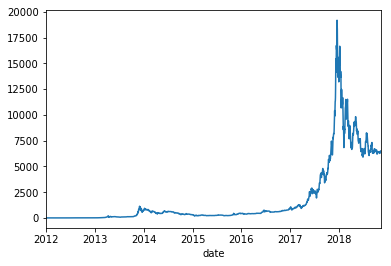

In [6]:
# Now let's take a look at a simple graph to see what the BTC prices have done
Daily_Price.plot()

In [7]:
# Finally, we'll take a look at the tail for the daily_prices
Daily_Price.tail()

date
2018-11-06    6413.277403
2018-11-07    6506.850121
2018-11-08    6448.400227
2018-11-09    6365.113235
2018-11-10    6354.594869
Name: Weighted_Price, dtype: float64

## Split our dataset

We need to **split our dataset** because we want to train and test the model only on some chunk of the data. So, in the next cell, we are splitting the data into training and test sets. For the sake of simplicity (since there are a lot of theories on how to split data, especially one with a short history of financial data), I will set a variable `Number_of_Test_Days = 200` that can be changed for anyone else who wants to take this notebook and do some experimenting.

In [8]:
Number_of_Test_Days = 200


#Now we are splitting our data into the train and test set:
df_train= Daily_Price[:len(Daily_Price)-Number_of_Test_Days]
df_test= Daily_Price[len(Daily_Price)-Number_of_Test_Days:]

# Just as a sanity-check
print("length of df_train: ", len(df_train))
print("length of df_test:  ", len(df_test))
print("length of total:    ", Daily_Price.size)

length of df_train:  2304
length of df_test:   200
length of total:     2504


# Cursory Data Analysis

We want to estimate some parameters of our data because this can be useful in the further mod|el designing. The first important thing when forecasting time series is to check if the data is stationary. That is, is our data influenced by factors such as trend or seasonality?

In the next cell, we concatenate train and test data to make analysis and transformations simultaneously.

In [9]:
working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
working_data['date'] = pd.to_datetime(working_data['date'])
working_data = working_data.set_index('date')

### Seasonal Decomposition

Next, we will perform a seasonal decomposition on the data (inevitable given the breadth and category of the data we are workign with) to estimate its trend and seasonality. We will plot it all out so we can see the actual price movements on the plot below (“observed”) as well as the trend and seasonality in our data.

We will be using `seasonal_decompose` function which is a part of the `time series analysis (tsa)` in `statsmodel`. Click [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) to read more about it.

Further, as mentioned above, we will be using plot.ly's line and scatter plots, which you can read more about [here](https://plot.ly/python/line-and-scatter/).

In [10]:
s = sm.tsa.seasonal_decompose(working_data.Weighted_Price.values, freq=60)

trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),
                    y = s.trend,mode = 'lines',
                    name = 'Trend',
                    line = dict(color = ('rgb(244, 93, 1)'), width = 2)
                   )

trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),
                    y = s.seasonal,mode = 'lines',
                    name = 'Seasonal',
                    line = dict(color = ('rgb(238, 185, 2)'),width = 2)
                   )

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),
                    y = s.resid,mode = 'lines',
                    name = 'Residual',
                    line = dict(color = ('rgb(151, 204, 4)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),
                    y = s.observed,mode = 'lines',
                    name = 'Observed',
                    line = dict(color = ('rgb(45, 125, 210)'), width = 2))

data = [trace1, trace2, trace3, trace4]

layout = dict(title = 'Seasonal decomposition',
              xaxis = dict(title = 'Time'),
              yaxis = dict(title = 'Price, USD')
             )

fig = dict(data=data,
           layout=layout)


py.iplot(fig, filename='seasonal_decomposition')


### Autocorrelation

Next, we need to look at the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation).


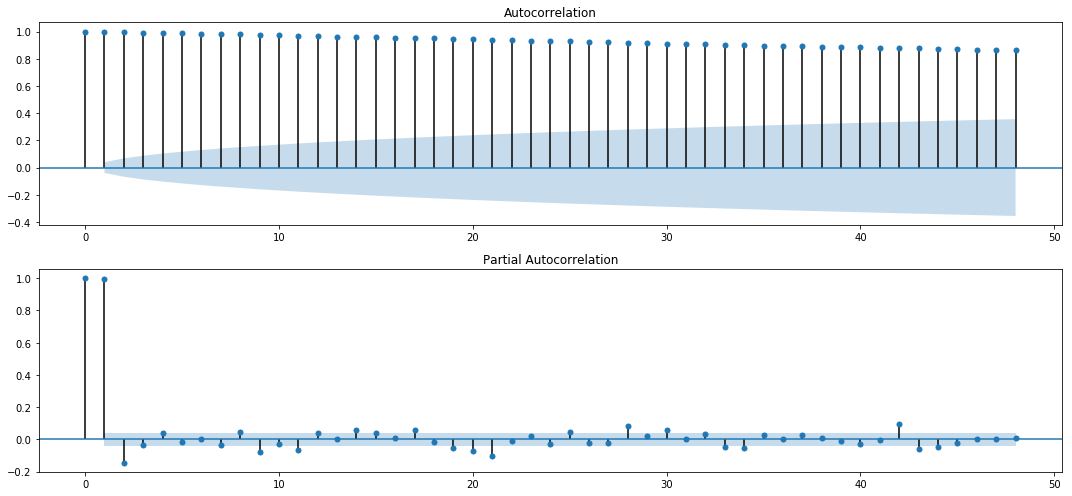

In [11]:

plt.figure(figsize=(15,7))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(working_data.Weighted_Price.values.squeeze(),
                         lags=48,
                         ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(working_data.Weighted_Price.values.squeeze(),
                          lags=48,
                          ax=ax)

plt.tight_layout()
plt.show()

Now we need to recover our df_train and df_test datasets:



In [12]:
close_train= Daily_Price[:len(Daily_Price)-Number_of_Test_Days]
close_test= Daily_Price[len(Daily_Price)-Number_of_Test_Days:]

# Data Preparation

We actually cleaned a lot of our data up above. Here, we will need to prepare our dataset according to the requirements of the model, as well as to split the dataset into train and test parts.

In the next cell, we reshape the train and test datasets according to the requirements of the model.
Scale the dataset by using the MinMaxScaler because LSTM models are scale sensitive.

In [13]:
#feature scalling (set values between 0-1)
close_train=np.array(close_train)
close_train=close_train.reshape(close_train.shape[0],1)

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_scaled=scaler.fit_transform(close_train)

# Models

The whole point of this is to compare RNN and LSTM. To that end, let's talk briefly about both models.


## RNN

The first thing to note about RNN is that they deal with **sequential data** to making predictions.

A more typical neural network (and arguable the most vanilla version) is the **feedforward neural network** (typically a convoluted Neural Network). In a feedforward network, the information moves in only one direction (forward) from the input nodes, through the hidden nodes, and finally to the output nodes. There are no cycles or loops in the network.

So, to deal with sequential data data, we need to use a **feedback** (recurrent) neural network. This network is able to "remember" parts of the inputs and use them to make more accurate predictions. These networks can use their internal state (memory) to process sequences of inputs, making these networks incredibly foundational for speech recognition and translation where order of words matter.

We should note, however, that the basic RNN still has some drawbacks. The main drawback is called the **vanishing gradient problem**. Without getting too techincal, the network experiences difficulty in remembering data points that are further back and makes predicitions are biased towards to the most recent data points. *This is one of the interesting point I want to look into in this thesis as conventional wisdom states that financial instruments historical data points should matter less the further back they are.* 

To fix the vanishing gradient problem, we will be using Long Short Term Memory (LSTM).

## LSTM

In an LSTM network, the neurons in an RNN are replaced with cells that can "remember" the past by using internal memory state and several "gates." These gates are neural network layers in their own right, learning a set of weight that allows them to determine what is important (to remember) and what is unnecessary (to forget).

By design, LSTM have no difficulty discerning connections over long sequences of data. Each cell's internal memory state allows it to keep any relative weighting intact over time. This makes LSTM the perfect candidate for price prediction, since market signals (cause and effect) can be far apart.

#### 1 Layer
The original LSTM model is comprised of a single hidden LSTM layer followed by a standard feedforward output layer.

#### 2+ Layer
The Stacked LSTM is an extension to this model that has multiple hidden LSTM layers where each layer contains multiple memory cells. Stacking LSTM hidden layers makes the model deeper, more accurately earning the description as a deep learning technique. But we also have to keep in mind the curse of dimensionality and the problem of overfitting by adding extra layers.

Given that LSTMs operate on sequence data, it means that the addition of layers adds levels of abstraction of input observations over time. In effect, chunking observations over time or representing the problem at different time scales.

With the introduction from [Graves, et al](https://arxiv.org/abs/1303.5778) in a paper about speech recognition, the community found that stacked LSTMs are a stable technique for challengeing sequence prediction problems (like the one we are tackling right now!). 


## Small Disclaimer

If you are familar with deep learning techniques, you will know there are quite a bit of knobs and variables you can adjust (even within one model) to make the model more suited to your needs, whether that is to make it more generalized or more specific. As a practicing data scientist, I know how long it can take to optimize each model to the data and its use, so I will generalize some of the more abstract variables (like `batch_size` `activation_function` `epochs`) and will simply keep them consistent throughout the different models.

# Predictions

Here, we actually run the code and train our models to see how they do!

First, let's define all the variables we will be using in all the models. That is to say, the training and testing data.

In [13]:
# here, we choose a timestemp to see how many previous days impacts the next point
# for instance, if i set this to 125, then we will look at 125 days before predicting the next one
timestep = 100
x_train=[]
y_train=[]

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i - timestep : i, 0])
    y_train.append(close_scaled[i, 0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (2204, 100, 1)
y_train shape=  (2204,)


## RNN

Here we will made an RNN model with only 1 layers.

In [27]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten


np.random.seed(215)


rnn_model = Sequential()

rnn_model.add(SimpleRNN(128,
                        activation = "relu",
                        return_sequences = True,
                        input_shape = (x_train.shape[1],1)))
rnn_model.add(Dropout(0.25))

#convert the matrix to 1-line
rnn_model.add(Flatten())

#output layer
rnn_model.add(Dense(1))

rnn_model.compile(optimizer="adam",
                  loss="mean_squared_error")

rnn_model.fit(x_train,
              y_train,
              epochs=20,
              batch_size=64)

Epoch 1/20
2204/2204 [==============================] - 2s 1ms/step - loss: 0.0059
Epoch 2/20
2204/2204 [==============================] - 2s 858us/step - loss: 0.0012
Epoch 3/20
2204/2204 [==============================] - 2s 840us/step - loss: 8.5298e-04
Epoch 4/20
2204/2204 [==============================] - 2s 845us/step - loss: 8.7412e-04
Epoch 5/20
2204/2204 [==============================] - 2s 841us/step - loss: 7.2348e-04
Epoch 6/20
2204/2204 [==============================] - 2s 848us/step - loss: 6.5573e-04
Epoch 7/20
2204/2204 [==============================] - 2s 841us/step - loss: 4.9234e-04
Epoch 8/20
2204/2204 [==============================] - 2s 848us/step - loss: 3.7039e-04
Epoch 9/20
2204/2204 [==============================] - 2s 844us/step - loss: 4.1347e-04
Epoch 10/20
2204/2204 [==============================] - 2s 841us/step - loss: 5.5662e-04
Epoch 11/20
2204/2204 [==============================] - 2s 842us/step - loss: 3.6476e-04
Epoch 12/20
2204/2204 [======

In [28]:
print(rnn_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 100, 128)          16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 12801     
Total params: 29,441
Trainable params: 29,441
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
inputs = Daily_Price[len(Daily_Price)-len(close_test)-timestep:]
inputs = inputs.values.reshape(-1,1)
inputs = scaler.transform(inputs)

In [30]:
x_test=[]
for i in range(timestep, inputs.shape[0]):
    x_test.append(inputs[i - timestep : i, 0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

predicted_data_rnn = rnn_model.predict(x_test)
predicted_data_rnn = scaler.inverse_transform(predicted_data_rnn)

data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

full_data = np.append(Daily_Price[:-Number_of_Test_Days].values, data_test)
full_predicted = np.append(np.empty(Daily_Price.shape[0]-Number_of_Test_Days), predicted_data_rnn)

In [32]:
#MSE
np.sqrt(((predicted_data_rnn - data_test) ** 2).mean())

384.667070825383

Cool, now lets draw it out.

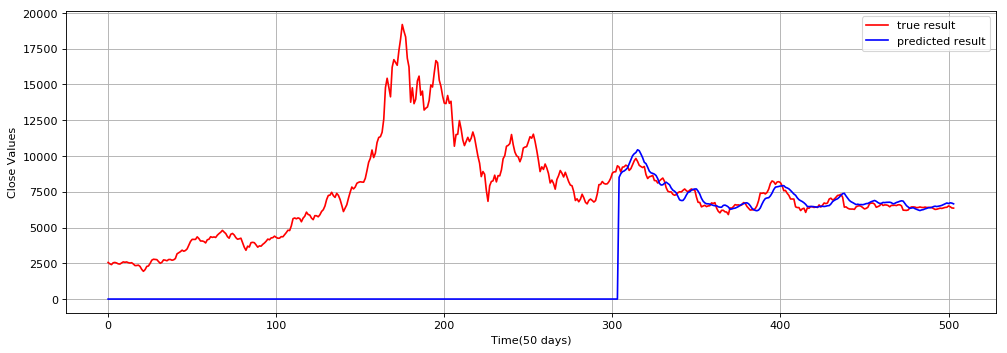

In [33]:
plt.figure(
    figsize=(15,5),
           dpi=80,
           facecolor='w')
#            edgecolor='k')
plt.plot(full_data[2000:],color="r",label="true result")
plt.plot(full_predicted[2000:],color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

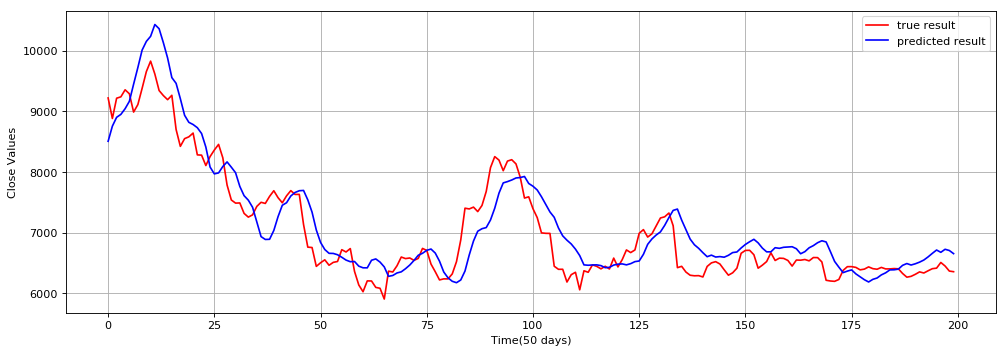

In [34]:
plt.figure(
    figsize=(15,5),
           dpi=80,
           facecolor='w')
#            edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data_rnn,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

## LSTM Neural Network

In [35]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

np.random.seed(215)

model = Sequential()

model.add(LSTM(128,
               input_shape=(None,1),
               activation="relu"))
model.add(Dropout(0.25))

model.add(Dense(1))

model.compile(loss="mean_squared_error",
              optimizer="adam")

model.fit(x_train,
          y_train,
          epochs=20,
          batch_size=64)

Epoch 1/20
2204/2204 [==============================] - 5s 2ms/step - loss: 0.0091
Epoch 2/20
2204/2204 [==============================] - 4s 2ms/step - loss: 0.0012
Epoch 3/20
2204/2204 [==============================] - 4s 2ms/step - loss: 9.4161e-04
Epoch 4/20
2204/2204 [==============================] - 4s 2ms/step - loss: 7.8227e-04
Epoch 5/20
2204/2204 [==============================] - 4s 2ms/step - loss: 6.9666e-04
Epoch 6/20
2204/2204 [==============================] - 4s 2ms/step - loss: 7.1747e-04
Epoch 7/20
2204/2204 [==============================] - 4s 2ms/step - loss: 6.7093e-04
Epoch 8/20
2204/2204 [==============================] - 4s 2ms/step - loss: 6.8801e-04
Epoch 9/20
2204/2204 [==============================] - 4s 2ms/step - loss: 7.0339e-04
Epoch 10/20
2204/2204 [==============================] - 4s 2ms/step - loss: 6.8503e-04
Epoch 11/20
2204/2204 [==============================] - 4s 2ms/step - loss: 6.1521e-04
Epoch 12/20
2204/2204 [==========================

In [36]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
inputs = Daily_Price[len(Daily_Price)-len(close_test)-timestep:]
inputs = inputs.values.reshape(-1,1)
inputs = scaler.transform(inputs)

x_test = []
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

predicted_data_lstm = model.predict(x_test)
predicted_data_lstm = scaler.inverse_transform(predicted_data_lstm)

data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

full_data = np.append(Daily_Price[:-Number_of_Test_Days].values, data_test)
full_predicted = np.append(np.empty(Daily_Price.shape[0]-Number_of_Test_Days), predicted_data_lstm)

In [38]:
#MSE
np.sqrt(((predicted_data_lstm - data_test) ** 2).mean())

304.9743095352

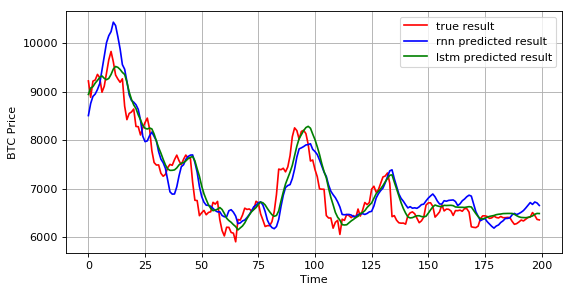

In [40]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data_rnn,color="b",label="rnn predicted result")
plt.plot(predicted_data_lstm,color="g",label="lstm predicted result")
plt.legend()
plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.grid(True)
plt.show()

 >[the success of deep neural networks] is commonly attributed to the hierarchy that is introduced due to the several layers. Each layer processes some part of the task we wish to solve, and passes it on to the next. In this sense, the DNN can be seen as a processing pipeline, in which each layer solves a part of the task before passing it on to the next, until finally the last layer provides the output.
   
[Training and Analyzing Deep Recurrent Neural Networks](https://papers.nips.cc/paper/5166-training-and-analysing-deep-recurrent-neural-networks), 2013

In [44]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

np.random.seed(215)

model_lstm2 = Sequential()

model_lstm2.add(LSTM(128,
               input_shape=(None,1),
               activation="relu"))
# model_lstm2.add(Dropout(0.25))

# model_lstm2.add(LSTM(128))
# model_lstm2.add(Dropout(0.25))

model_lstm2.add(Dense(1))

model_lstm2.compile(loss="mean_squared_error",
              optimizer="adam")

model_lstm2.fit(x_train,
          y_train,
          epochs=20,
          batch_size=64)

Epoch 1/20
2204/2204 [==============================] - 5s 2ms/step - loss: 0.0087
Epoch 2/20
2204/2204 [==============================] - 4s 2ms/step - loss: 7.2148e-04
Epoch 3/20
2204/2204 [==============================] - 4s 2ms/step - loss: 4.9860e-04
Epoch 4/20
2204/2204 [==============================] - 4s 2ms/step - loss: 4.2464e-04
Epoch 5/20
2204/2204 [==============================] - 4s 2ms/step - loss: 3.6651e-04
Epoch 6/20
2204/2204 [==============================] - 4s 2ms/step - loss: 3.7292e-04
Epoch 7/20
2204/2204 [==============================] - 4s 2ms/step - loss: 3.6011e-04
Epoch 8/20
2204/2204 [==============================] - 4s 2ms/step - loss: 3.7205e-04
Epoch 9/20
2204/2204 [==============================] - 4s 2ms/step - loss: 3.7413e-04
Epoch 10/20
2204/2204 [==============================] - 4s 2ms/step - loss: 3.1286e-04
Epoch 11/20
2204/2204 [==============================] - 4s 2ms/step - loss: 2.9340e-04
Epoch 12/20
2204/2204 [======================

In [48]:
#MSE
np.sqrt(((predicted_data_lstm2 - data_test) ** 2).mean())

374.6221722334509

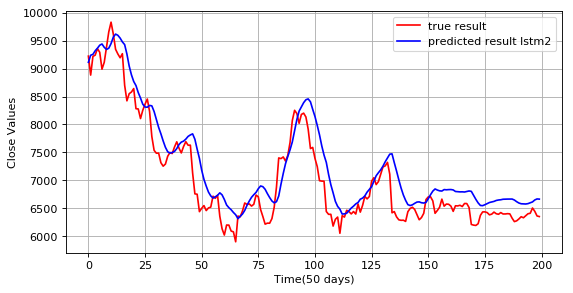

In [46]:
inputs=Daily_Price[len(Daily_Price)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)



x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

predicted_data_lstm2 = model_lstm2.predict(x_test)
predicted_data_lstm2 = scaler.inverse_transform(predicted_data_lstm2)

data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data_lstm2,color="b",label="predicted result lstm2")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

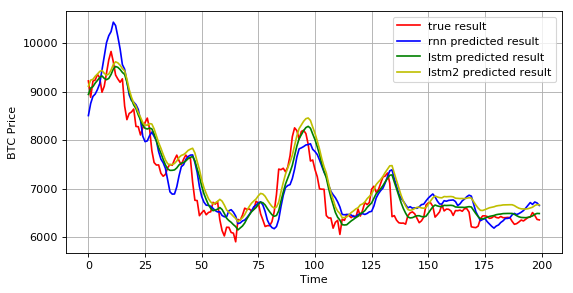

In [47]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data_rnn,color="b",label="rnn predicted result")
plt.plot(predicted_data_lstm,color="g",label="lstm predicted result")
plt.plot(predicted_data_lstm2,color="y",label="lstm2 predicted result")
plt.legend()
plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.grid(True)
plt.show()

# Comparison
